In [22]:
import torch
print(torch.__version__)  # Should be 2.9.0+cu126
print(torch.cuda.is_available())  # Should be True
x = torch.rand(5, 3, device='cuda')
print(x)  # Should show a tensor on cuda:0

2.9.0+cu126
True
tensor([[0.0669, 0.9448, 0.2207],
        [0.2721, 0.0079, 0.7900],
        [0.2900, 0.6759, 0.4983],
        [0.2745, 0.5800, 0.8281],
        [0.3880, 0.5462, 0.4864]], device='cuda:0')


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

# Sklearn packages
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error,
    classification_report, 
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# SMOTE for class imbalance
from imblearn.over_sampling import SMOTE

# PyTorch packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds for reproducibility
np.random.seed(123)
torch.manual_seed(123)
if torch.cuda.is_available():
    torch.cuda.manual_seed(123)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA RTX A2000 8GB Laptop GPU


In [24]:
csv_file_path = r'C:\Users\delro\Downloads\datacsv\data.csv' 
data = pd.read_csv(csv_file_path)
print(data.head())  # Verify it loaded


   Bankrupt?   ROA(C) before interest and depreciation before interest  \
0          1                                           0.370594          
1          1                                           0.464291          
2          1                                           0.426071          
3          1                                           0.399844          
4          1                                           0.465022          

    ROA(A) before interest and % after tax  \
0                                 0.424389   
1                                 0.538214   
2                                 0.499019   
3                                 0.451265   
4                                 0.538432   

    ROA(B) before interest and depreciation after tax  \
0                                           0.405750    
1                                           0.516730    
2                                           0.472295    
3                                           0.4577

In [58]:
print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)
print(f"\nShape: {data.shape}")
print(f"Observations: {len(data):,}")
print(f"Features: {len(data.columns)}")

print("\n" + "=" * 80)
print("CLASS DISTRIBUTION")
print("=" * 80)
bankrupt_counts = data['Bankrupt?'].value_counts()
print(f"\nNon-Bankrupt (0): {bankrupt_counts[0]:,} ({bankrupt_counts[0]/len(data)*100:.2f}%)")
print(f"Bankrupt (1): {bankrupt_counts[1]:,} ({bankrupt_counts[1]/len(data)*100:.2f}%)")
print(f"\n⚠️ Imbalance Ratio: {bankrupt_counts[0]/bankrupt_counts[1]:.1f}:1")

print("\n" + "=" * 80)
print("FIRST 5 ROWS")
print("=" * 80)
display(data.head())
display(data.describe())

DATASET OVERVIEW

Shape: (6819, 96)
Observations: 6,819
Features: 96

CLASS DISTRIBUTION

Non-Bankrupt (0): 6,599 (96.77%)
Bankrupt (1): 220 (3.23%)

⚠️ Imbalance Ratio: 30.0:1

FIRST 5 ROWS


,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,...,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,...,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686,0.065620,0.061595,0.016934,0.016916,0.013010,0.012869,0.013601,0.011163,...,0.040332,3.764501e+08,0.012290,0.016934,0.014523,0.014463,0.015668,0.013214,0.0,0.050014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,0.000000,0.476527,0.535543,0.527277,0.600445,0.600434,0.998969,0.797386,0.809312,0.303466,...,0.796750,9.036205e-04,0.623636,0.600443,0.840115,0.276944,0.026791,0.565158,1.0,0.024477
50%,0.000000,0.502706,0.559802,0.552278,0.605997,0.605976,0.999022,0.797464,0.809375,0.303525,...,0.810619,2.085213e-03,0.623879,0.605998,0.841179,0.278778,0.026808,0.565252,1.0,0.033798
75%,0.000000,0.535563,0.589157,0.584105,0.613914,0.613842,0.999095,0.797579,0.809469,0.303585,...,0.826455,5.269777e-03,0.624168,0.613913,0.842357,0.281449,0.026913,0.565725,1.0,0.052838
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,9.820000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


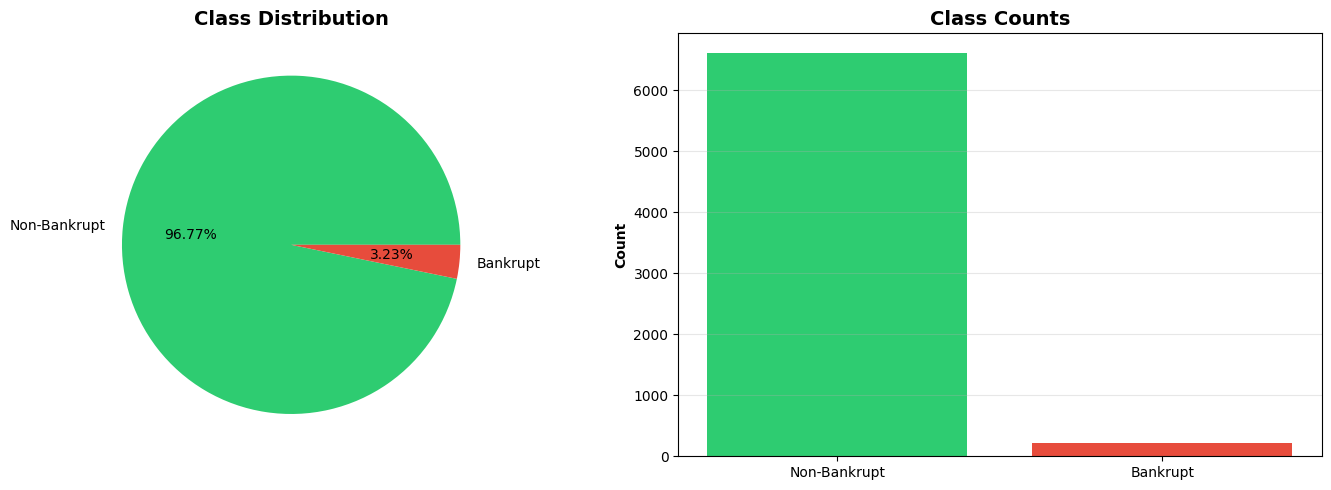

In [8]:
# Create visualizations directory
import os
os.makedirs('visualizations', exist_ok=True)

# Figure 1: Class Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
axes[0].pie(bankrupt_counts, labels=['Non-Bankrupt', 'Bankrupt'], 
            autopct='%1.2f%%', colors=['#2ecc71', '#e74c3c'])
axes[0].set_title('Class Distribution', fontsize=14, fontweight='bold')

# Bar chart
axes[1].bar(['Non-Bankrupt', 'Bankrupt'], bankrupt_counts, color=['#2ecc71', '#e74c3c'])
axes[1].set_ylabel('Count', fontweight='bold')
axes[1].set_title('Class Counts', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('visualizations/1_class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

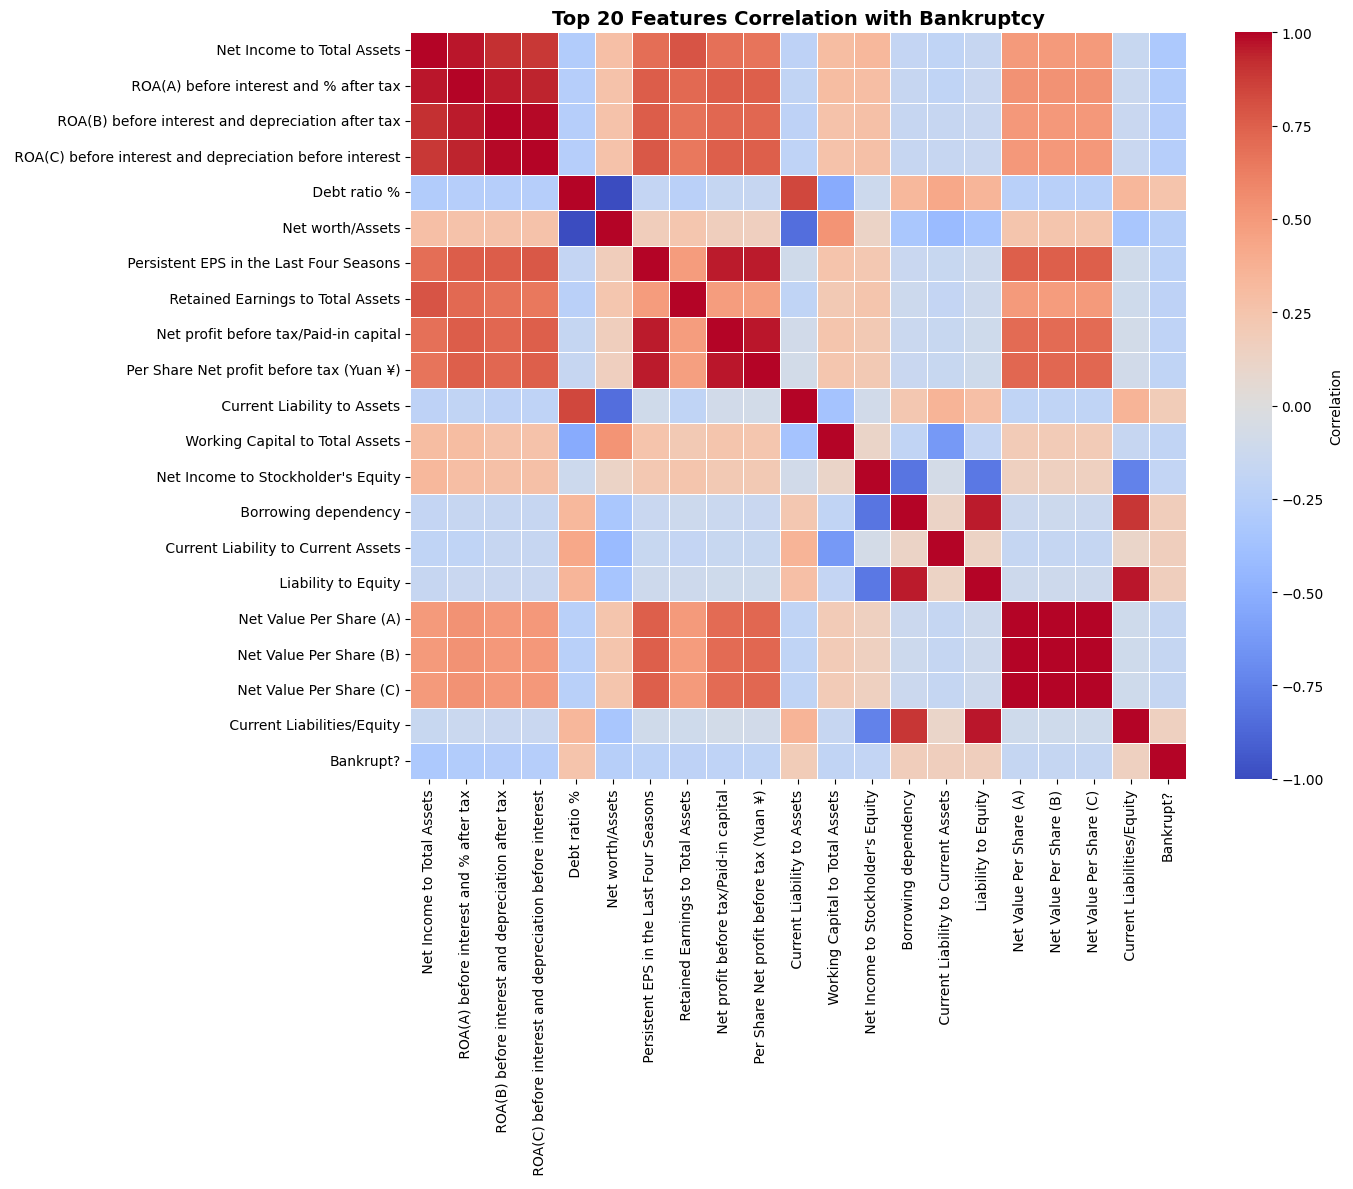


Top 20 Features Most Correlated with Bankruptcy:
Net Income to Total Assets                                 0.315457
ROA(A) before interest and % after tax                     0.282941
ROA(B) before interest and depreciation after tax          0.273051
ROA(C) before interest and depreciation before interest    0.260807
Debt ratio %                                               0.250161
Net worth/Assets                                           0.250161
Persistent EPS in the Last Four Seasons                    0.219560
Retained Earnings to Total Assets                          0.217779
Net profit before tax/Paid-in capital                      0.207857
Per Share Net profit before tax (Yuan ¥)                   0.201395
Current Liability to Assets                                0.194494
Working Capital to Total Assets                            0.193083
Net Income to Stockholder's Equity                         0.180987
Borrowing dependency                                       0.17654

In [26]:
# Figure 2: Feature Correlation Heatmap (sample of top features)
# Select top 20 features by correlation with bankruptcy
X = data.drop('Bankrupt?', axis=1)
y = data['Bankrupt?']

correlations = X.corrwith(y).abs().sort_values(ascending=False)
top_20_features = correlations.head(20).index.tolist()

# Create correlation matrix
corr_matrix = data[top_20_features + ['Bankrupt?']].corr()

# Plot
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, 
            linewidths=0.5, cbar_kws={'label': 'Correlation'})
plt.title('Top 20 Features Correlation with Bankruptcy', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('visualizations/2_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTop 20 Features Most Correlated with Bankruptcy:")
print(correlations.head(20))

In [27]:
# Separate features and target
X = data.drop('Bankrupt?', axis=1)
y = data['Bankrupt?']

print("Original class distribution:")
print(y.value_counts())
print(f"\nImbalance ratio: {sum(y==0)/sum(y==1):.1f}:1")

# Split BEFORE SMOTE (to avoid data leakage)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=123, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=123, stratify=y_temp
)  # 0.176 * 0.85 ≈ 0.15 of total

print(f"\nSplit sizes:")
print(f"Train: {len(X_train)} ({len(X_train)/len(data)*100:.1f}%)")
print(f"Validation: {len(X_val)} ({len(X_val)/len(data)*100:.1f}%)")
print(f"Test: {len(X_test)} ({len(X_test)/len(data)*100:.1f}%)")

print("All columns and dtypes:")
print(X_train.dtypes)

binary_cols = [col for col in X_train.columns if X_train[col].nunique() <= 2 and set(X_train[col].unique()).issubset({0, 1, np.nan})]
categorical_cols = []  # Add any known categoricals; dataset is mostly numeric, but check for any
print("\nBinary columns (do not scale):", binary_cols)
print("Categorical columns (do not scale):", categorical_cols)

# Select only non-binary/non-categorical numeric columns for scaling
numeric_cols = [col for col in X_train.columns if col not in binary_cols + categorical_cols]

# Initialize scaler
scaler = StandardScaler()

# Fit on training data's numeric cols only, then transform train/val/test
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

print("\nData standardized (numeric non-binary/categorical only).")

# Apply SMOTE only to training data
smote = SMOTE(random_state=123)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"\n=" * 80)
print("AFTER SMOTE (Training Set Only)")
print("=" * 80)
print(f"Original training: {len(X_train)} samples")
print(f"Balanced training: {len(X_train_balanced)} samples")
print(f"\nBalanced class distribution:")
print(pd.Series(y_train_balanced).value_counts())
print(f"\n✓ Classes are now perfectly balanced in training set")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_balanced.values)
y_train_tensor = torch.FloatTensor(y_train_balanced.values)
X_val_tensor = torch.FloatTensor(X_val.values)
y_val_tensor = torch.FloatTensor(y_val.values)
X_test_tensor = torch.FloatTensor(X_test.values)
y_test_tensor = torch.FloatTensor(y_test.values)

Original class distribution:
Bankrupt?
0    6599
1     220
Name: count, dtype: int64

Imbalance ratio: 30.0:1

Split sizes:
Train: 4775 (70.0%)
Validation: 1021 (15.0%)
Test: 1023 (15.0%)
All columns and dtypes:
ROA(C) before interest and depreciation before interest    float64
ROA(A) before interest and % after tax                     float64
ROA(B) before interest and depreciation after tax          float64
Operating Gross Margin                                     float64
Realized Sales Gross Margin                                float64
                                                            ...   
Liability to Equity                                        float64
Degree of Financial Leverage (DFL)                         float64
Interest Coverage Ratio (Interest expense to EBIT)         float64
Net Income Flag                                              int64
Equity to Liability                                        float64
Length: 95, dtype: object

Binary columns (do not s

In [28]:
# Test PCA with multiple component counts
pca_results = {}

for n_components in [2, 5, 10, 15, 20]:
    print(f"\n{'='*80}")
    print(f"PCA with {n_components} components")
    print(f"{'='*80}")
    
    # Fit PCA on training data
    pca = PCA(n_components=n_components)
    pca.fit(X_train_balanced)
    
    # Transform and reconstruct
    X_train_pca = pca.transform(X_train_balanced)
    X_train_reconstructed = pca.inverse_transform(X_train_pca)
    
    X_val_pca = pca.transform(X_val)
    X_val_reconstructed = pca.inverse_transform(X_val_pca)
    
    X_test_pca = pca.transform(X_test)
    X_test_reconstructed = pca.inverse_transform(X_test_pca)
    
    # Calculate reconstruction errors
    train_mse = mean_squared_error(X_train_balanced, X_train_reconstructed)
    val_mse = mean_squared_error(X_val, X_val_reconstructed)
    test_mse = mean_squared_error(X_test, X_test_reconstructed)
    
    train_mae = mean_absolute_error(X_train_balanced, X_train_reconstructed)
    val_mae = mean_absolute_error(X_val, X_val_reconstructed)
    test_mae = mean_absolute_error(X_test, X_test_reconstructed)
    
    # Explained variance
    explained_var = pca.explained_variance_ratio_.sum()
    
    # Store results
    pca_results[n_components] = {
        'model': pca,
        'train_mse': train_mse,
        'val_mse': val_mse,
        'test_mse': test_mse,
        'train_mae': train_mae,
        'val_mae': val_mae,
        'test_mae': test_mae,
        'explained_variance': explained_var,
        'X_train_pca': X_train_pca,
        'X_val_pca': X_val_pca,
        'X_test_pca': X_test_pca
    }
    
    print(f"  Train MSE: {train_mse:.6f}")
    print(f"  Val MSE: {val_mse:.6f}")
    print(f"  Test MSE: {test_mse:.6f}")
    print(f"  Explained Variance: {explained_var*100:.2f}%")

# Summary table
pca_summary = pd.DataFrame([
    {
        'Components': k,
        'Test MSE': results['test_mse'],
        'Test MAE': results['test_mae'],
        'Explained Var %': results['explained_variance'] * 100
    }
    for k, results in pca_results.items()
])

print(f"\n{'='*80}")
print("PCA SUMMARY TABLE")
print(f"{'='*80}")
display(pca_summary)


PCA with 2 components
  Train MSE: 0.794166
  Val MSE: 29.293790
  Test MSE: 4.204677
  Explained Variance: 37.42%

PCA with 5 components
  Train MSE: 0.605036
  Val MSE: 29.198428
  Test MSE: 4.121345
  Explained Variance: 52.33%

PCA with 10 components
  Train MSE: 0.431784
  Val MSE: 29.039519
  Test MSE: 3.946948
  Explained Variance: 65.98%

PCA with 15 components
  Train MSE: 0.319589
  Val MSE: 28.556684
  Test MSE: 3.728272
  Explained Variance: 74.82%

PCA with 20 components
  Train MSE: 0.246181
  Val MSE: 28.099975
  Test MSE: 2.871581
  Explained Variance: 80.60%

PCA SUMMARY TABLE


,Components,Test MSE,Test MAE,Explained Var %
0,2,4.204677,0.363668,37.423185
1,5,4.121345,0.343535,52.325806
2,10,3.946948,0.308498,65.977325
3,15,3.728272,0.279904,74.817738
4,20,2.871581,0.252573,80.602010


In [29]:
# BASELINE: Undercomplete Autoencoder
class UndercompleteAutoencoder(nn.Module):
    """Deep autoencoder with bottleneck constraint"""
    def __init__(self, input_dim, latent_dim, activation='leakyrelu'):
        super(UndercompleteAutoencoder, self).__init__()
        
        # Choose activation function
        if activation == 'relu':
            act = nn.ReLU()
        elif activation == 'leakyrelu':
            act = nn.LeakyReLU(0.2)
        elif activation == 'sigmoid':
            act = nn.Sigmoid()
        else:
            raise ValueError(f"Unknown activation: {activation}")
        
        # Encoder: 96 → 64 → 32 → 16 → latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            act,
            nn.Linear(64, 32),
            act,
            nn.Linear(32, 16),
            act,
            nn.Linear(16, latent_dim)
        )
        
        # Decoder: latent_dim → 16 → 32 → 64 → 96
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            act,
            nn.Linear(16, 32),
            act,
            nn.Linear(32, 64),
            act,
            nn.Linear(64, input_dim)
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        return self.encoder(x)


# VARIATION 1: Sparse Autoencoder (with L1 regularization on latent code)
class SparseAutoencoder(nn.Module):
    """Autoencoder with sparsity constraint on latent representation"""
    def __init__(self, input_dim, latent_dim, sparsity_weight=1e-3):
        super(SparseAutoencoder, self).__init__()
        self.sparsity_weight = sparsity_weight
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, latent_dim),
            nn.LeakyReLU(0.2)  # Allow sparse activations
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, input_dim)
        )
    
    def forward(self, x):
        self.encoded = self.encoder(x)
        decoded = self.decoder(self.encoded)
        return decoded
    
    def encode(self, x):
        return self.encoder(x)
    
    def sparsity_loss(self):
        """L1 penalty on latent representation"""
        return self.sparsity_weight * torch.mean(torch.abs(self.encoded))


In [30]:
# VARIATION 2: Denoising Autoencoder
class DenoisingAutoencoder(nn.Module):
    """Autoencoder trained to reconstruct clean input from corrupted input"""
    def __init__(self, input_dim, latent_dim, noise_factor=0.2):
        super(DenoisingAutoencoder, self).__init__()
        self.noise_factor = noise_factor
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, latent_dim)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, input_dim)
        )
    
    def add_noise(self, x):
        """Add Gaussian noise to input"""
        noise = torch.randn_like(x) * self.noise_factor
        return x + noise
    
    def forward(self, x, add_noise=True):
        if add_noise and self.training:
            x = self.add_noise(x)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        return self.encoder(x)

In [31]:
# VARIATION 3: Autoencoder with Dropout
class DropoutAutoencoder(nn.Module):
    """Autoencoder with dropout regularization"""
    def __init__(self, input_dim, latent_dim, dropout_rate=0.2):
        super(DropoutAutoencoder, self).__init__()
        
        # Encoder with dropout
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(32, latent_dim)
        )
        
        # Decoder with dropout
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(32, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(64, input_dim)
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        return self.encoder(x)

In [32]:
# VARIATION 4: Contractive Autoencoder
class ContractiveAutoencoder(nn.Module):
    """Autoencoder with contractive penalty on encoder Jacobian"""
    def __init__(self, input_dim, latent_dim, contractive_weight=1e-4):
        super(ContractiveAutoencoder, self).__init__()
        self.contractive_weight = contractive_weight
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, latent_dim)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, input_dim)
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        return self.encoder(x)
    
    def contractive_loss(self, x, h):
        """Frobenius norm of Jacobian"""
        # Compute Jacobian: dh/dx
        dh = torch.autograd.grad(
            outputs=h,
            inputs=x,
            grad_outputs=torch.ones_like(h),
            create_graph=True,
            retain_graph=True
        )[0]
        
        # Frobenius norm (squared)
        contractive_penalty = torch.sum(dh ** 2)
        return self.contractive_weight * contractive_penalty

In [33]:
# VARIATION 5: Shallow Autoencoder (for depth comparison)
class ShallowAutoencoder(nn.Module):
    """Single hidden layer autoencoder"""
    def __init__(self, input_dim, latent_dim):
        super(ShallowAutoencoder, self).__init__()
        
        # Encoder: 96 → latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, latent_dim),
            nn.LeakyReLU(0.2)
        )
        
        # Decoder: latent_dim → 96
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, input_dim)
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        return self.encoder(x)

print("✓ All autoencoder architectures defined")

✓ All autoencoder architectures defined


## 7. Training Function (Flexible for All Variants)

In [34]:
def train_autoencoder(
    model,
    X_train,
    X_val,
    loss_fn='mse',
    optimizer_type='adam',
    learning_rate=0.001,
    epochs=5000,
    patience=500,
    batch_size=256,
    device='cuda',
    model_name='autoencoder',
    use_gpu_timing=False
):
    """
    Comprehensive training function for all autoencoder variants
    
    Parameters:
    -----------
    model : nn.Module
        Autoencoder model
    loss_fn : str
        'mse', 'mae', or 'bce'
    optimizer_type : str
        'adam' or 'sgd'
    use_gpu_timing : bool
        If True, force GPU usage for timing comparison
    """
    
    # Set device
    if use_gpu_timing and torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device(device)

    # Warn if fallback happened
    if device.type == 'cpu' and 'cuda' in str(device):
        print("Warning: CUDA requested but not available—falling back to CPU.")
    
    model = model.to(device)
    X_train = X_train.to(device)
    X_val = X_val.to(device)
    
    # Define loss function
    if loss_fn == 'mse':
        criterion = nn.MSELoss()
    elif loss_fn == 'mae':
        criterion = nn.L1Loss()
    elif loss_fn == 'bce':
        criterion = nn.BCEWithLogitsLoss()
    else:
        raise ValueError(f"Unknown loss function: {loss_fn}")
    
    # Define optimizer
    if optimizer_type == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_type == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_type}")
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'epoch_times': []
    }
    
    # Early stopping
    best_loss = float('inf')
    best_epoch = 0
    counter = 0
    
    # Start timing
    total_start_time = time.time()
    
    print(f"\nTraining {model_name}...")
    print(f"Device: {device}")
    print(f"Loss: {loss_fn}, Optimizer: {optimizer_type}, LR: {learning_rate}")
    
    for epoch in range(epochs):
        epoch_start = time.time()
        
        # Training
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        if isinstance(model, DenoisingAutoencoder):
            output = model(X_train, add_noise=True)
        else:
            output = model(X_train)
        
        # Calculate loss
        loss = criterion(output, X_train)
        
        # Add regularization if applicable
        if isinstance(model, SparseAutoencoder):
            loss = loss + model.sparsity_loss()
        elif isinstance(model, ContractiveAutoencoder):
            # Contractive loss requires gradient computation
            X_train.requires_grad = True
            h = model.encode(X_train)
            loss = loss + model.contractive_loss(X_train, h)
            X_train.requires_grad = False
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        train_loss = loss.item()
        
        # Validation
        model.eval()
        with torch.no_grad():
            if isinstance(model, DenoisingAutoencoder):
                val_output = model(X_val, add_noise=False)
            else:
                val_output = model(X_val)
            val_loss = criterion(val_output, X_val).item()
        
        # Record history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['epoch_times'].append(time.time() - epoch_start)
        
        # Early stopping check
        if val_loss < best_loss:
            best_loss = val_loss
            best_epoch = epoch
            # Save best model
            torch.save(model.state_dict(), f'models/{model_name}_best.pth')
            counter = 0
        else:
            counter += 1
        
        # Progress reporting
        if epoch % 500 == 0 and epoch > 0:
            print(f"  Epoch {epoch}/{epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")
        
        # Early stopping
        if counter >= patience:
            print(f"\n  Early stopping at epoch {epoch}")
            print(f"  Best validation loss: {best_loss:.6f} at epoch {best_epoch}")
            break
    
    total_time = time.time() - total_start_time
    
    # Load best model
    model.load_state_dict(torch.load(f'models/{model_name}_best.pth'))
    
    print(f"\n  ✓ Training complete")
    print(f"  Total time: {total_time:.2f}s")
    print(f"  Best epoch: {best_epoch}")
    print(f"  Best val loss: {best_loss:.6f}")
    
    return model, history, total_time

# Create models directory
os.makedirs('models', exist_ok=True)

print("✓ Training function defined")

✓ Training function defined


## 8. EXPERIMENT 1: Baseline Autoencoder (k=2, 5, 10, 15, 20)

In [35]:
# Dictionary to store all results
autoencoder_results = {}

# Test different bottleneck sizes
latent_dims = [2, 5, 10, 15, 20]

for k in latent_dims:
    print(f"\n{'='*80}")
    print(f"BASELINE AUTOENCODER - Latent Dimension = {k}")
    print(f"{'='*80}")
    
    # Initialize model
    model = UndercompleteAutoencoder(
        input_dim=95, 
        latent_dim=k, 
        activation='leakyrelu'
    )
    
    # Train model
    trained_model, history, train_time = train_autoencoder(
        model=model,
        X_train=X_train_tensor,
        X_val=X_val_tensor,
        loss_fn='mse',
        optimizer_type='adam',
        learning_rate=0.001,
        epochs=5000,
        patience=500,
        device=device,
        model_name=f'baseline_k{k}'
    )
    
    # Evaluate on test set
    trained_model.eval()
    with torch.no_grad():
        X_test_reconstructed = trained_model(X_test_tensor.to(device))
        test_mse = nn.MSELoss()(X_test_reconstructed, X_test_tensor.to(device)).item()
        test_mae = nn.L1Loss()(X_test_reconstructed, X_test_tensor.to(device)).item()
    
    # Get latent representations
    with torch.no_grad():
        X_train_encoded = trained_model.encode(X_train_tensor.to(device)).cpu().numpy()
        X_val_encoded = trained_model.encode(X_val_tensor.to(device)).cpu().numpy()
        X_test_encoded = trained_model.encode(X_test_tensor.to(device)).cpu().numpy()
    
    # Store results
    autoencoder_results[f'baseline_k{k}'] = {
        'model': trained_model,
        'latent_dim': k,
        'history': history,
        'train_time': train_time,
        'test_mse': test_mse,
        'test_mae': test_mae,
        'X_train_encoded': X_train_encoded,
        'X_val_encoded': X_val_encoded,
        'X_test_encoded': X_test_encoded,
        'architecture': 'Deep (95→64→32→16→k→16→32→64→95)',
        'regularization': 'None (undercomplete)',
        'optimizer': 'Adam',
        'loss': 'MSE'
    }
    
    print(f"\n  Final Test MSE: {test_mse:.6f}")
    print(f"  Final Test MAE: {test_mae:.6f}")
    print(f"  Training Time: {train_time:.2f}s")


BASELINE AUTOENCODER - Latent Dimension = 2

Training baseline_k2...
Device: cuda
Loss: mse, Optimizer: adam, LR: 0.001
  Epoch 500/5000 | Train Loss: 0.446444 | Val Loss: 29.738886

  Early stopping at epoch 790
  Best validation loss: 28.968649 at epoch 290

  ✓ Training complete
  Total time: 12.92s
  Best epoch: 290
  Best val loss: 28.968649

  Final Test MSE: 3.911049
  Final Test MAE: 0.338844
  Training Time: 12.92s

BASELINE AUTOENCODER - Latent Dimension = 5

Training baseline_k5...
Device: cuda
Loss: mse, Optimizer: adam, LR: 0.001
  Epoch 500/5000 | Train Loss: 0.324551 | Val Loss: 27.926600

  Early stopping at epoch 947
  Best validation loss: 27.301455 at epoch 447

  ✓ Training complete
  Total time: 18.95s
  Best epoch: 447
  Best val loss: 27.301455

  Final Test MSE: 3.828010
  Final Test MAE: 0.313516
  Training Time: 18.95s

BASELINE AUTOENCODER - Latent Dimension = 10

Training baseline_k10...
Device: cuda
Loss: mse, Optimizer: adam, LR: 0.001
  Epoch 500/5000 | 

## 9. EXPERIMENT 2: Shallow vs Deep Architecture (k=10)

In [36]:
print(f"\n{'='*80}")
print("EXPERIMENT 2: Depth Comparison (k=10)")
print(f"{'='*80}")

# Shallow autoencoder
shallow_model = ShallowAutoencoder(input_dim=95, latent_dim=10)

shallow_trained, shallow_history, shallow_time = train_autoencoder(
    model=shallow_model,
    X_train=X_train_tensor,
    X_val=X_val_tensor,
    loss_fn='mse',
    optimizer_type='adam',
    learning_rate=0.001,
    device=device,
    model_name='shallow_k10'
)

# Evaluate
shallow_trained.eval()
with torch.no_grad():
    shallow_test_recon = shallow_trained(X_test_tensor.to(device))
    shallow_test_mse = nn.MSELoss()(shallow_test_recon, X_test_tensor.to(device)).item()

autoencoder_results['shallow_k10'] = {
    'model': shallow_trained,
    'latent_dim': 10,
    'history': shallow_history,
    'train_time': shallow_time,
    'test_mse': shallow_test_mse,
    'architecture': 'Shallow (95→10→95)',
    'regularization': 'None',
    'optimizer': 'Adam',
    'loss': 'MSE'
}

print(f"\nShallow Autoencoder Test MSE: {shallow_test_mse:.6f}")
print(f"Deep Autoencoder Test MSE: {autoencoder_results['baseline_k10']['test_mse']:.6f}")
print(f"\nDifference: {abs(shallow_test_mse - autoencoder_results['baseline_k10']['test_mse']):.6f}")


EXPERIMENT 2: Depth Comparison (k=10)

Training shallow_k10...
Device: cuda
Loss: mse, Optimizer: adam, LR: 0.001
  Epoch 500/5000 | Train Loss: 0.494923 | Val Loss: 29.605280

  Early stopping at epoch 634
  Best validation loss: 28.736280 at epoch 134

  ✓ Training complete
  Total time: 5.35s
  Best epoch: 134
  Best val loss: 28.736280

Shallow Autoencoder Test MSE: 4.115966
Deep Autoencoder Test MSE: 3.658684

Difference: 0.457281


## 10. EXPERIMENT 3: Optimizer Comparison (Adam vs SGD, k=10)

In [38]:
print(f"\n{'='*80}")
print("EXPERIMENT 3: Optimizer Comparison (k=10)")
print(f"{'='*80}")

# SGD optimizer
sgd_model = UndercompleteAutoencoder(input_dim=95, latent_dim=10)

sgd_trained, sgd_history, sgd_time = train_autoencoder(
    model=sgd_model,
    X_train=X_train_tensor,
    X_val=X_val_tensor,
    optimizer_type='sgd',
    learning_rate=0.01,  # Higher LR for SGD
    device=device,
    model_name='sgd_k10'
)

# Evaluate
sgd_trained.eval()
with torch.no_grad():
    sgd_test_recon = sgd_trained(X_test_tensor.to(device))
    sgd_test_mse = nn.MSELoss()(sgd_test_recon, X_test_tensor.to(device)).item()

autoencoder_results['sgd_k10'] = {
    'model': sgd_trained,
    'latent_dim': 10,
    'test_mse': sgd_test_mse,
    'train_time': sgd_time,
    'history': sgd_history,
    'optimizer': 'SGD'
}

print(f"\nAdam Test MSE: {autoencoder_results['baseline_k10']['test_mse']:.6f}")
print(f"SGD Test MSE: {sgd_test_mse:.6f}")


EXPERIMENT 3: Optimizer Comparison (k=10)

Training sgd_k10...
Device: cuda
Loss: mse, Optimizer: sgd, LR: 0.01
  Epoch 500/5000 | Train Loss: 1.267606 | Val Loss: 30.045029

  Early stopping at epoch 561
  Best validation loss: 29.977139 at epoch 61

  ✓ Training complete
  Total time: 10.48s
  Best epoch: 61
  Best val loss: 29.977139

Adam Test MSE: 3.658684
SGD Test MSE: 4.845706


## 11. EXPERIMENT 4: Activation Function Comparison (k=10)

In [40]:
print(f"\n{'='*80}")
print("EXPERIMENT 4: Activation Function Comparison (k=10)")
print(f"{'='*80}")

activation_functions = ['relu', 'sigmoid']

for act in activation_functions:
    print(f"\nTesting {act.upper()} activation...")
    
    model = UndercompleteAutoencoder(input_dim=95, latent_dim=10, activation=act)
    
    trained, history, train_time = train_autoencoder(
        model=model,
        X_train=X_train_tensor,
        X_val=X_val_tensor,
        device=device,
        model_name=f'{act}_k10'
    )
    
    # Evaluate
    trained.eval()
    with torch.no_grad():
        test_recon = trained(X_test_tensor.to(device))
        test_mse = nn.MSELoss()(test_recon, X_test_tensor.to(device)).item()
    
    autoencoder_results[f'{act}_k10'] = {
        'model': trained,
        'latent_dim': 10,
        'test_mse': test_mse,
        'train_time': train_time,
        'activation': act
    }
    
    print(f"  {act.upper()} Test MSE: {test_mse:.6f}")

# Compare
print(f"\n{'='*80}")
print("ACTIVATION COMPARISON SUMMARY")
print(f"{'='*80}")
print(f"LeakyReLU: {autoencoder_results['baseline_k10']['test_mse']:.6f}")
print(f"ReLU: {autoencoder_results['relu_k10']['test_mse']:.6f}")
print(f"Sigmoid: {autoencoder_results['sigmoid_k10']['test_mse']:.6f}")


EXPERIMENT 4: Activation Function Comparison (k=10)

Testing RELU activation...

Training relu_k10...
Device: cuda
Loss: mse, Optimizer: adam, LR: 0.001
  Epoch 500/5000 | Train Loss: 0.296144 | Val Loss: 28.994970
  Epoch 1000/5000 | Train Loss: 0.216645 | Val Loss: 24.251671
  Epoch 1500/5000 | Train Loss: 0.190218 | Val Loss: 16.005339
  Epoch 2000/5000 | Train Loss: 0.175111 | Val Loss: 16.767038

  Early stopping at epoch 2257
  Best validation loss: 14.662562 at epoch 1757

  ✓ Training complete
  Total time: 46.55s
  Best epoch: 1757
  Best val loss: 14.662562
  RELU Test MSE: 2.258382

Testing SIGMOID activation...

Training sigmoid_k10...
Device: cuda
Loss: mse, Optimizer: adam, LR: 0.001
  Epoch 500/5000 | Train Loss: 0.981824 | Val Loss: 29.729633
  Epoch 1000/5000 | Train Loss: 0.900194 | Val Loss: 29.637482
  Epoch 1500/5000 | Train Loss: 0.858181 | Val Loss: 29.625950

  Early stopping at epoch 1955
  Best validation loss: 29.618570 at epoch 1455

  ✓ Training complete
 

## 12. EXPERIMENT 5: Regularization Techniques (k=10)

In [43]:
print(f"\n{'='*80}")
print("EXPERIMENT 5: Regularization Comparison (k=10)")
print(f"{'='*80}")

# 5.1 Dropout Autoencoder
print("\n[1/4] Testing Dropout Autoencoder...")
dropout_model = DropoutAutoencoder(input_dim=95, latent_dim=10, dropout_rate=0.2)
dropout_trained, dropout_history, dropout_time = train_autoencoder(
    model=dropout_model,
    X_train=X_train_tensor,
    X_val=X_val_tensor,
    device=device,
    model_name='dropout_k10'
)

dropout_trained.eval()
with torch.no_grad():
    dropout_test_mse = nn.MSELoss()(dropout_trained(X_test_tensor.to(device)), X_test_tensor.to(device)).item()

autoencoder_results['dropout_k10'] = {
    'model': dropout_trained,
    'test_mse': dropout_test_mse,
    'regularization': 'Dropout (0.2)'
}

# 5.2 Sparse Autoencoder
print("\n[2/4] Testing Sparse Autoencoder...")
sparse_model = SparseAutoencoder(input_dim=95, latent_dim=10, sparsity_weight=1e-3)
sparse_trained, sparse_history, sparse_time = train_autoencoder(
    model=sparse_model,
    X_train=X_train_tensor,
    X_val=X_val_tensor,
    device=device,
    model_name='sparse_k10'
)

sparse_trained.eval()
with torch.no_grad():
    sparse_test_mse = nn.MSELoss()(sparse_trained(X_test_tensor.to(device)), X_test_tensor.to(device)).item()

autoencoder_results['sparse_k10'] = {
    'model': sparse_trained,
    'test_mse': sparse_test_mse,
    'regularization': 'Sparse (L1)'
}

# 5.3 Denoising Autoencoder
print("\n[3/4] Testing Denoising Autoencoder...")
denoising_model = DenoisingAutoencoder(input_dim=95, latent_dim=10, noise_factor=0.2)
denoising_trained, denoising_history, denoising_time = train_autoencoder(
    model=denoising_model,
    X_train=X_train_tensor,
    X_val=X_val_tensor,
    device=device,
    model_name='denoising_k10'
)

denoising_trained.eval()
with torch.no_grad():
    denoising_test_mse = nn.MSELoss()(denoising_trained(X_test_tensor.to(device), add_noise=False), X_test_tensor.to(device)).item()

autoencoder_results['denoising_k10'] = {
    'model': denoising_trained,
    'test_mse': denoising_test_mse,
    'regularization': 'Denoising'
}

# 5.4 Contractive Autoencoder
print("\n[4/4] Testing Contractive Autoencoder...")
contractive_model = ContractiveAutoencoder(input_dim=95, latent_dim=10, contractive_weight=1e-4)
contractive_trained, contractive_history, contractive_time = train_autoencoder(
    model=contractive_model,
    X_train=X_train_tensor,
    X_val=X_val_tensor,
    device=device,
    model_name='contractive_k10'
)

contractive_trained.eval()
with torch.no_grad():
    contractive_test_mse = nn.MSELoss()(contractive_trained(X_test_tensor.to(device)), X_test_tensor.to(device)).item()

autoencoder_results['contractive_k10'] = {
    'model': contractive_trained,
    'test_mse': contractive_test_mse,
    'regularization': 'Contractive'
}

# Summary
print(f"\n{'='*80}")
print("REGULARIZATION COMPARISON SUMMARY (k=10)")
print(f"{'='*80}")
print(f"Baseline (Undercomplete): {autoencoder_results['baseline_k10']['test_mse']:.6f}")
print(f"Dropout: {dropout_test_mse:.6f}")
print(f"Sparse: {sparse_test_mse:.6f}")
print(f"Denoising: {denoising_test_mse:.6f}")
print(f"Contractive: {contractive_test_mse:.6f}")


EXPERIMENT 5: Regularization Comparison (k=10)

[1/4] Testing Dropout Autoencoder...

Training dropout_k10...
Device: cuda
Loss: mse, Optimizer: adam, LR: 0.001
  Epoch 500/5000 | Train Loss: 0.525832 | Val Loss: 28.563162

  Early stopping at epoch 712
  Best validation loss: 28.323004 at epoch 212

  ✓ Training complete
  Total time: 13.08s
  Best epoch: 212
  Best val loss: 28.323004

[2/4] Testing Sparse Autoencoder...

Training sparse_k10...
Device: cuda
Loss: mse, Optimizer: adam, LR: 0.001
  Epoch 500/5000 | Train Loss: 0.206151 | Val Loss: 26.210014
  Epoch 1000/5000 | Train Loss: 0.143701 | Val Loss: 14.347852
  Epoch 1500/5000 | Train Loss: 0.123891 | Val Loss: 11.337739
  Epoch 2000/5000 | Train Loss: 0.111640 | Val Loss: 11.095851

  Early stopping at epoch 2271
  Best validation loss: 10.917546 at epoch 1771

  ✓ Training complete
  Total time: 42.80s
  Best epoch: 1771
  Best val loss: 10.917546

[3/4] Testing Denoising Autoencoder...

Training denoising_k10...
Device: c

## 13. EXPERIMENT 6: Loss Function Comparison (k=10)

In [44]:
print(f"\n{'='*80}")
print("EXPERIMENT 6: Loss Function Comparison (k=10)")
print(f"{'='*80}")

loss_functions = ['mae', 'bce']

for loss_fn in loss_functions:
    print(f"\nTesting {loss_fn.upper()} loss...")
    
    model = UndercompleteAutoencoder(input_dim=95, latent_dim=10)
    
    trained, history, train_time = train_autoencoder(
        model=model,
        X_train=X_train_tensor,
        X_val=X_val_tensor,
        loss_fn=loss_fn,
        device=device,
        model_name=f'{loss_fn}_k10'
    )
    
    # Evaluate with MSE for comparison
    trained.eval()
    with torch.no_grad():
        test_recon = trained(X_test_tensor.to(device))
        test_mse = nn.MSELoss()(test_recon, X_test_tensor.to(device)).item()
    
    autoencoder_results[f'{loss_fn}_k10'] = {
        'model': trained,
        'test_mse': test_mse,
        'loss': loss_fn.upper()
    }
    
    print(f"  {loss_fn.upper()} Test MSE: {test_mse:.6f}")

# Summary
print(f"\n{'='*80}")
print("LOSS FUNCTION COMPARISON (k=10)")
print(f"{'='*80}")
print(f"MSE Loss: {autoencoder_results['baseline_k10']['test_mse']:.6f}")
print(f"MAE Loss: {autoencoder_results['mae_k10']['test_mse']:.6f}")
print(f"BCE Loss: {autoencoder_results['bce_k10']['test_mse']:.6f}")


EXPERIMENT 6: Loss Function Comparison (k=10)

Testing MAE loss...

Training mae_k10...
Device: cuda
Loss: mae, Optimizer: adam, LR: 0.001
  Epoch 500/5000 | Train Loss: 0.211376 | Val Loss: 0.250006
  Epoch 1000/5000 | Train Loss: 0.184954 | Val Loss: 0.229928
  Epoch 1500/5000 | Train Loss: 0.169149 | Val Loss: 0.213990
  Epoch 2000/5000 | Train Loss: 0.156714 | Val Loss: 0.203708

  Early stopping at epoch 2465
  Best validation loss: 0.203467 at epoch 1965

  ✓ Training complete
  Total time: 59.95s
  Best epoch: 1965
  Best val loss: 0.203467
  MAE Test MSE: 3.808592

Testing BCE loss...

Training bce_k10...
Device: cuda
Loss: bce, Optimizer: adam, LR: 0.001
  Epoch 500/5000 | Train Loss: -77792428032.000000 | Val Loss: -151153115136.000000
  Epoch 1000/5000 | Train Loss: -34892100403200.000000 | Val Loss: -78385149640704.000000
  Epoch 1500/5000 | Train Loss: -829036129419264.000000 | Val Loss: -1928698550812672.000000
  Epoch 2000/5000 | Train Loss: -6669389499727872.000000 | V

## 14. EXPERIMENT 7: GPU vs CPU Timing Comparison (k=10)

In [45]:
print(f"\n{'='*80}")
print("EXPERIMENT 7: Hardware Comparison (k=10)")
print(f"{'='*80}")

# CPU Training
print("\n[1/2] Training on CPU...")
cpu_model = UndercompleteAutoencoder(input_dim=95, latent_dim=10)
cpu_trained, cpu_history, cpu_time = train_autoencoder(
    model=cpu_model,
    X_train=X_train_tensor,
    X_val=X_val_tensor,
    epochs=1000,  # Reduced for timing comparison
    device='cpu',
    model_name='cpu_k10'
)

# GPU Training (if available)
if torch.cuda.is_available():
    print("\n[2/2] Training on GPU...")
    gpu_model = UndercompleteAutoencoder(input_dim=95, latent_dim=10)
    gpu_trained, gpu_history, gpu_time = train_autoencoder(
        model=gpu_model,
        X_train=X_train_tensor,
        X_val=X_val_tensor,
        epochs=1000,
        use_gpu_timing=True,
        model_name='gpu_k10'
    )
    
    print(f"\n{'='*80}")
    print("HARDWARE TIMING COMPARISON")
    print(f"{'='*80}")
    print(f"CPU Time: {cpu_time:.2f}s")
    print(f"GPU Time: {gpu_time:.2f}s")
    print(f"Speedup: {cpu_time/gpu_time:.2f}x faster on GPU")
else:
    print("\n⚠️ GPU not available - skipping GPU comparison")


EXPERIMENT 7: Hardware Comparison (k=10)

[1/2] Training on CPU...

Training cpu_k10...
Device: cpu
Loss: mse, Optimizer: adam, LR: 0.001
  Epoch 500/1000 | Train Loss: 0.292570 | Val Loss: 27.592014

  ✓ Training complete
  Total time: 63.61s
  Best epoch: 992
  Best val loss: 25.317785

[2/2] Training on GPU...

Training gpu_k10...
Device: cuda
Loss: mse, Optimizer: adam, LR: 0.001
  Epoch 500/1000 | Train Loss: 0.295750 | Val Loss: 28.018120

  ✓ Training complete
  Total time: 19.97s
  Best epoch: 996
  Best val loss: 26.517351

HARDWARE TIMING COMPARISON
CPU Time: 63.61s
GPU Time: 19.97s
Speedup: 3.19x faster on GPU


## 15. Comprehensive Results Comparison: PCA vs Autoencoders

In [46]:
# Create comprehensive comparison table
comparison_data = []

# Add PCA results
for k in [2, 5, 10, 15, 20]:
    comparison_data.append({
        'Model': 'PCA',
        'Latent Dim': k,
        'Test MSE': pca_results[k]['test_mse'],
        'Test MAE': pca_results[k]['test_mae'],
        'Train Time (s)': 'N/A (instant)',
        'Explained Var %': pca_results[k]['explained_variance'] * 100
    })

# Add baseline autoencoder results
for k in [2, 5, 10, 15, 20]:
    results = autoencoder_results[f'baseline_k{k}']
    comparison_data.append({
        'Model': 'Autoencoder (Baseline)',
        'Latent Dim': k,
        'Test MSE': results['test_mse'],
        'Test MAE': results.get('test_mae', 'N/A'),
        'Train Time (s)': results['train_time'],
        'Explained Var %': 'N/A'
    })

comparison_df = pd.DataFrame(comparison_data)

print(f"\n{'='*80}")
print("COMPREHENSIVE MODEL COMPARISON")
print(f"{'='*80}")
display(comparison_df)

# Save to CSV
comparison_df.to_csv('results/model_comparison.csv', index=False)
print("\n✓ Results saved to results/model_comparison.csv")


COMPREHENSIVE MODEL COMPARISON


,Model,Latent Dim,Test MSE,Test MAE,Train Time (s),Explained Var %
0,PCA,2,4.204677,0.363668,N/A (instant),37.423185
1,PCA,5,4.121345,0.343535,N/A (instant),52.325806
2,PCA,10,3.946948,0.308498,N/A (instant),65.977325
3,PCA,15,3.728272,0.279904,N/A (instant),74.817738
4,PCA,20,2.871581,0.252573,N/A (instant),80.60201
5,Autoencoder (Baseline),2,3.911049,0.338844,12.918848,N/A
6,Autoencoder (Baseline),5,3.828010,0.313516,18.95357,N/A
7,Autoencoder (Baseline),10,3.658684,0.307620,20.734455,N/A
8,Autoencoder (Baseline),15,4.070613,0.389266,11.692185,N/A
9,Autoencoder (Baseline),20,2.104669,0.268524,72.720318,N/A


OSError: Cannot save file into a non-existent directory: 'results'

## 16. Visualization: Reconstruction Error by Latent Dimension

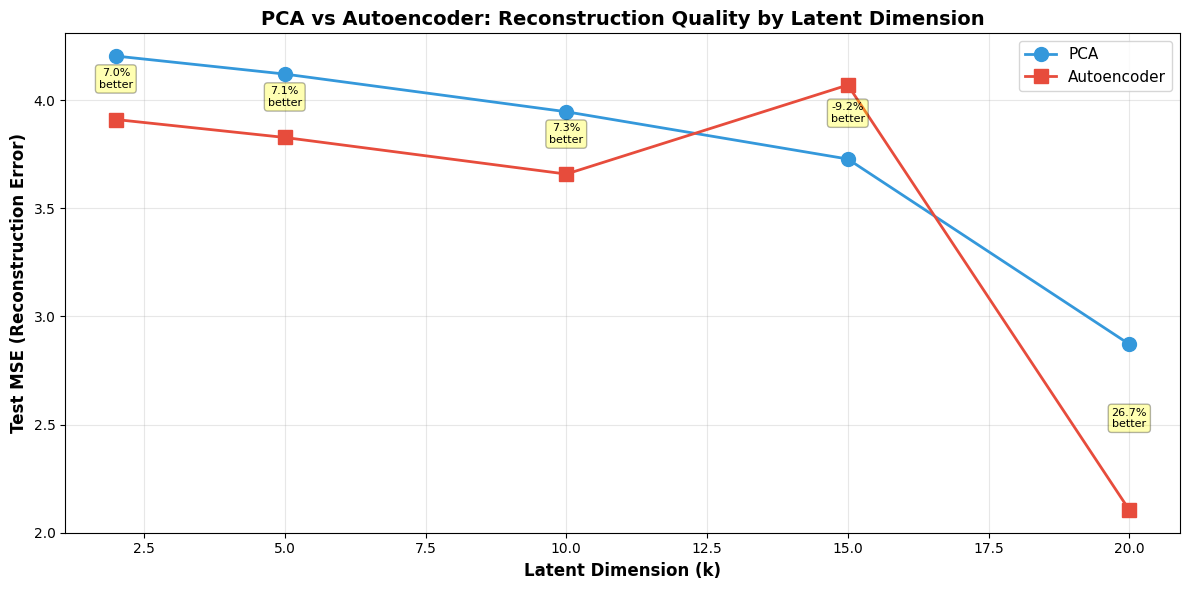

In [47]:
# Plot PCA vs Autoencoder reconstruction error
fig, ax = plt.subplots(figsize=(12, 6))

latent_dims = [2, 5, 10, 15, 20]
pca_mses = [pca_results[k]['test_mse'] for k in latent_dims]
ae_mses = [autoencoder_results[f'baseline_k{k}']['test_mse'] for k in latent_dims]

ax.plot(latent_dims, pca_mses, marker='o', linewidth=2, markersize=10, 
        label='PCA', color='#3498db')
ax.plot(latent_dims, ae_mses, marker='s', linewidth=2, markersize=10, 
        label='Autoencoder', color='#e74c3c')

ax.set_xlabel('Latent Dimension (k)', fontsize=12, fontweight='bold')
ax.set_ylabel('Test MSE (Reconstruction Error)', fontsize=12, fontweight='bold')
ax.set_title('PCA vs Autoencoder: Reconstruction Quality by Latent Dimension', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

# Annotate improvements
for k, pca_mse, ae_mse in zip(latent_dims, pca_mses, ae_mses):
    improvement = ((pca_mse - ae_mse) / pca_mse) * 100
    ax.annotate(f'{improvement:.1f}%\nbetter', 
                xy=(k, ae_mse), 
                xytext=(k, (pca_mse + ae_mse)/2),
                ha='center', fontsize=8, 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

plt.tight_layout()
plt.savefig('visualizations/3_pca_vs_autoencoder_by_k.png', dpi=300, bbox_inches='tight')
plt.show()

## 17. Visualization: Convergence Plots

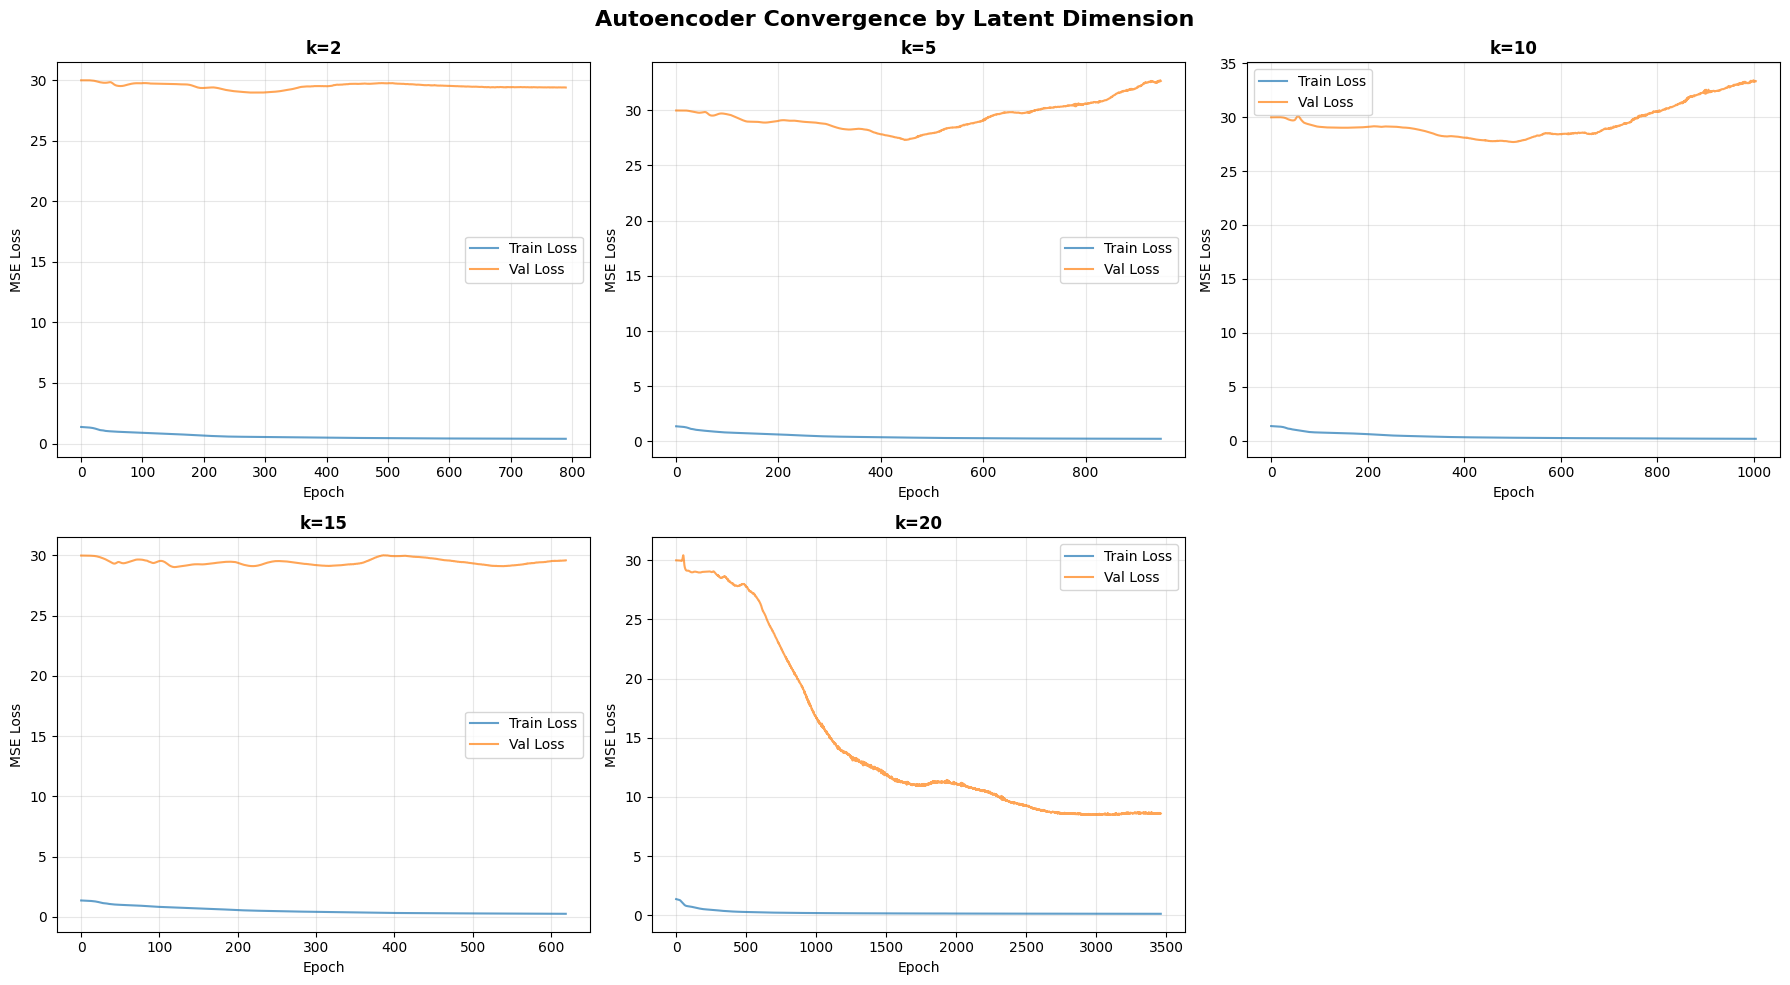

In [48]:
# Plot convergence for baseline models (k=2, 5, 10, 15, 20)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, k in enumerate([2, 5, 10, 15, 20]):
    history = autoencoder_results[f'baseline_k{k}']['history']
    
    axes[idx].plot(history['train_loss'], label='Train Loss', alpha=0.7)
    axes[idx].plot(history['val_loss'], label='Val Loss', alpha=0.7)
    axes[idx].set_xlabel('Epoch')
    axes[idx].set_ylabel('MSE Loss')
    axes[idx].set_title(f'k={k}', fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

# Remove extra subplot
fig.delaxes(axes[5])

fig.suptitle('Autoencoder Convergence by Latent Dimension', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('visualizations/4_convergence_plots.png', dpi=300, bbox_inches='tight')
plt.show()

## 18. Latent Space Visualization (k=2)

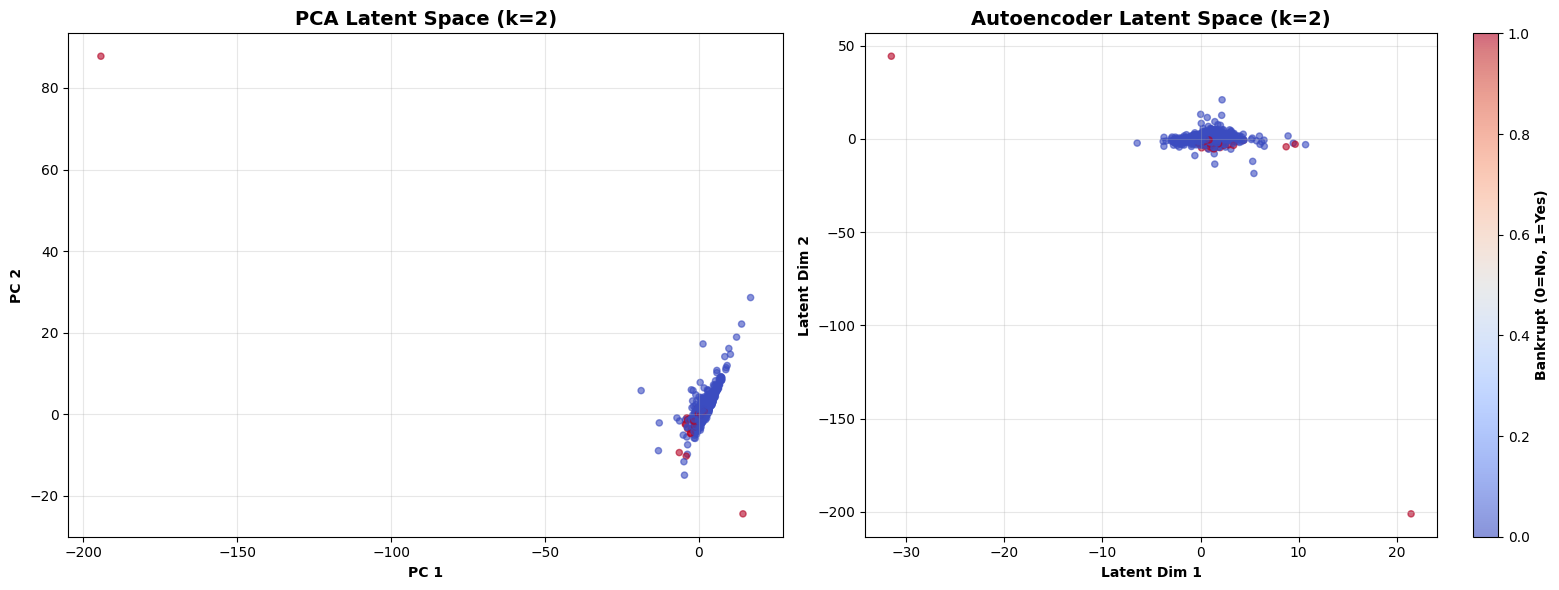


✓ Do bankrupt companies cluster separately in latent space?
   Visual inspection suggests that outside of some companies with outlier values, the majority of companies that are bankrupt and not bankrupt display the same profile when k=2


In [52]:
# Visualize 2D latent space for PCA and Autoencoder
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PCA Latent Space
axes[0].scatter(
    pca_results[2]['X_test_pca'][:, 0],
    pca_results[2]['X_test_pca'][:, 1],
    c=y_test,
    cmap='coolwarm',
    alpha=0.6,
    s=20
)
axes[0].set_xlabel('PC 1', fontweight='bold')
axes[0].set_ylabel('PC 2', fontweight='bold')
axes[0].set_title('PCA Latent Space (k=2)', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Autoencoder Latent Space
ae_latent_2d = autoencoder_results['baseline_k2']['X_test_encoded']
scatter = axes[1].scatter(
    ae_latent_2d[:, 0],
    ae_latent_2d[:, 1],
    c=y_test,
    cmap='coolwarm',
    alpha=0.6,
    s=20
)
axes[1].set_xlabel('Latent Dim 1', fontweight='bold')
axes[1].set_ylabel('Latent Dim 2', fontweight='bold')
axes[1].set_title('Autoencoder Latent Space (k=2)', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

# Colorbar
cbar = plt.colorbar(scatter, ax=axes[1])
cbar.set_label('Bankrupt (0=No, 1=Yes)', fontweight='bold')

plt.tight_layout()
plt.savefig('visualizations/5_latent_space_2d.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Do bankrupt companies cluster separately in latent space?")
print("   Visual inspection suggests that outside of some companies with outlier values, the majority of companies that are bankrupt and not bankrupt display the same profile when k=2")

## 19. BANKRUPTCY PREDICTION: Using Learned Representations

In [53]:
# Compare bankruptcy prediction using:
# 1. Raw 96 features
# 2. PCA-reduced features (k=10)
# 3. Autoencoder-reduced features (k=10)

print(f"\n{'='*80}")
print("BANKRUPTCY PREDICTION COMPARISON")
print(f"{'='*80}")

classification_results = {}

# Helper function
def evaluate_classifier(X_train, X_test, y_train, y_test, name):
    """Train logistic regression and evaluate"""
    clf = LogisticRegression(max_iter=1000, random_state=123)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    
    return {
        'name': name,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    }

# 1. Raw features (96 dimensions)
print("\n[1/3] Raw Features (96 dimensions)...")
raw_results = evaluate_classifier(
    X_train_balanced, X_test, y_train_balanced, y_test, 'Raw Features'
)
classification_results['raw'] = raw_results

# 2. PCA features (k=10)
print("[2/3] PCA Features (10 dimensions)...")
pca_clf_results = evaluate_classifier(
    pca_results[10]['X_train_pca'], 
    pca_results[10]['X_test_pca'],
    y_train_balanced, 
    y_test,
    'PCA (k=10)'
)
classification_results['pca'] = pca_clf_results

# 3. Autoencoder features (k=10)
print("[3/3] Autoencoder Features (10 dimensions)...")
ae_clf_results = evaluate_classifier(
    autoencoder_results['baseline_k10']['X_train_encoded'],
    autoencoder_results['baseline_k10']['X_test_encoded'],
    y_train_balanced,
    y_test,
    'Autoencoder (k=10)'
)
classification_results['autoencoder'] = ae_clf_results

# Summary table
clf_comparison = pd.DataFrame([raw_results, pca_clf_results, ae_clf_results])

print(f"\n{'='*80}")
print("BANKRUPTCY CLASSIFICATION PERFORMANCE")
print(f"{'='*80}")
display(clf_comparison)

clf_comparison.to_csv('results/classification_comparison.csv', index=False)
print("\n✓ Classification results saved")


BANKRUPTCY PREDICTION COMPARISON

[1/3] Raw Features (96 dimensions)...
[2/3] PCA Features (10 dimensions)...
[3/3] Autoencoder Features (10 dimensions)...

BANKRUPTCY CLASSIFICATION PERFORMANCE


,name,accuracy,precision,recall,f1,roc_auc
0,Raw Features,0.884653,0.189781,0.787879,0.305882,0.904591
1,PCA (k=10),0.859238,0.167665,0.848485,0.280000,0.930272
2,Autoencoder (k=10),0.855327,0.167630,0.878788,0.281553,0.925865


OSError: Cannot save file into a non-existent directory: 'results'

## 20. Final Summary and Insights

In [54]:
print(f"\n{'='*80}")
print("FINAL SUMMARY: KEY INSIGHTS")
print(f"{'='*80}")

# Best reconstruction model
best_ae_k = min([(k, autoencoder_results[f'baseline_k{k}']['test_mse']) 
                 for k in [2, 5, 10, 15, 20]], key=lambda x: x[1])
best_pca_k = min([(k, pca_results[k]['test_mse']) 
                  for k in [2, 5, 10, 15, 20]], key=lambda x: x[1])

print(f"\n1. BEST RECONSTRUCTION:")
print(f"   Autoencoder (k={best_ae_k[0]}): MSE = {best_ae_k[1]:.6f}")
print(f"   PCA (k={best_pca_k[0]}): MSE = {best_pca_k[1]:.6f}")

# Improvement
improvement = ((best_pca_k[1] - best_ae_k[1]) / best_pca_k[1]) * 100
print(f"   ➜ Autoencoder is {improvement:.2f}% better than PCA")

# Best classification
print(f"\n2. BEST BANKRUPTCY PREDICTION:")
for name, results in classification_results.items():
    print(f"   {results['name']}: AUC = {results['roc_auc']:.4f}")

# Best regularization
print(f"\n3. REGULARIZATION IMPACT (k=10):")
reg_models = ['baseline_k10', 'dropout_k10', 'sparse_k10', 'denoising_k10', 'contractive_k10']
for model_name in reg_models:
    if model_name in autoencoder_results:
        reg_type = autoencoder_results[model_name].get('regularization', 'Unknown')
        test_mse = autoencoder_results[model_name]['test_mse']
        print(f"   {reg_type}: MSE = {test_mse:.6f}")

print(f"\n{'='*80}")
print("ANALYSIS COMPLETE")
print(f"{'='*80}")
print("\n✓ All experiments completed successfully")
print("✓ Results saved to results/")
print("✓ Visualizations saved to visualizations/")
print("✓ Models saved to models/")


FINAL SUMMARY: KEY INSIGHTS

1. BEST RECONSTRUCTION:
   Autoencoder (k=20): MSE = 2.104669
   PCA (k=20): MSE = 2.871581
   ➜ Autoencoder is 26.71% better than PCA

2. BEST BANKRUPTCY PREDICTION:
   Raw Features: AUC = 0.9046
   PCA (k=10): AUC = 0.9303
   Autoencoder (k=10): AUC = 0.9259

3. REGULARIZATION IMPACT (k=10):
   None (undercomplete): MSE = 3.658684
   Dropout (0.2): MSE = 3.921843
   Sparse (L1): MSE = 2.456610
   Denoising: MSE = 2.419677
   Contractive: MSE = 2.095488

ANALYSIS COMPLETE

✓ All experiments completed successfully
✓ Results saved to results/
✓ Visualizations saved to visualizations/
✓ Models saved to models/


In [55]:
"""
Comprehensive Visualization Script for Autoencoder vs PCA Analysis
Creates all publication-quality charts for the bankruptcy prediction project
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create output directory
import os
os.makedirs('visualizations', exist_ok=True)
os.makedirs('results', exist_ok=True)

print("="*80)
print("GENERATING ALL VISUALIZATIONS")
print("="*80)

GENERATING ALL VISUALIZATIONS


In [56]:
# ==========================================
# VISUALIZATION 1: Class Distribution
# ==========================================
def plot_class_distribution(data):
    """Plot bankruptcy class distribution"""
    print("\n1. Creating class distribution chart...")
    
    bankrupt_counts = data['Bankrupt?'].value_counts()
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Pie chart
    axes[0].pie(bankrupt_counts, labels=['Non-Bankrupt', 'Bankrupt'], 
                autopct='%1.2f%%', colors=['#2ecc71', '#e74c3c'],
                startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
    axes[0].set_title('Class Distribution', fontsize=14, fontweight='bold')
    
    # Bar chart
    bars = axes[1].bar(['Non-Bankrupt', 'Bankrupt'], bankrupt_counts, 
                       color=['#2ecc71', '#e74c3c'])
    axes[1].set_ylabel('Count', fontweight='bold')
    axes[1].set_title('Class Counts', fontsize=14, fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height):,}',
                    ha='center', va='bottom', fontweight='bold')
    
    # Imbalance visualization
    imbalance_ratio = bankrupt_counts[0] / bankrupt_counts[1]
    axes[2].barh(['Imbalance Ratio'], [imbalance_ratio], color='#f39c12', height=0.4)
    axes[2].set_xlabel('Ratio (Non-Bankrupt : Bankrupt)', fontweight='bold')
    axes[2].set_title('Class Imbalance', fontsize=14, fontweight='bold')
    axes[2].grid(axis='x', alpha=0.3)
    axes[2].text(imbalance_ratio + 1, 0, f'{imbalance_ratio:.1f}:1', 
                va='center', fontweight='bold', fontsize=12)
    
    plt.tight_layout()
    plt.savefig('visualizations/1_class_distribution.png', dpi=300, bbox_inches='tight')
    plt.close()
    print("   ✓ Saved: visualizations/1_class_distribution.png")

In [57]:
# ==========================================
# VISUALIZATION 2: Feature Correlation Heatmap
# ==========================================
def plot_feature_correlations(data, top_n=20):
    """Plot correlation heatmap of top features with bankruptcy"""
    print(f"\n2. Creating feature correlation heatmap (top {top_n})...")
    
    X = data.drop('Bankrupt?', axis=1)
    y = data['Bankrupt?']
    
    # Find top features correlated with bankruptcy
    correlations = X.corrwith(y).abs().sort_values(ascending=False)
    top_features = correlations.head(top_n).index.tolist()
    
    # Create correlation matrix
    corr_data = data[top_features + ['Bankrupt?']]
    corr_matrix = corr_data.corr()
    
    # Plot
    fig, ax = plt.subplots(figsize=(16, 14))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0,
                linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'},
                ax=ax)
    ax.set_title(f'Top {top_n} Features Correlation with Bankruptcy', 
                 fontsize=16, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.savefig('visualizations/2_correlation_heatmap.png', dpi=300, bbox_inches='tight')
    plt.close()
    print("   ✓ Saved: visualizations/2_correlation_heatmap.png")
    
    # Also create a bar chart of top correlations
    fig, ax = plt.subplots(figsize=(12, 8))
    top_corr = correlations.head(20)
    colors = plt.cm.Reds(np.linspace(0.5, 0.9, len(top_corr)))
    bars = ax.barh(range(len(top_corr)), top_corr.values, color=colors)
    ax.set_yticks(range(len(top_corr)))
    ax.set_yticklabels([name[:50] for name in top_corr.index], fontsize=9)
    ax.set_xlabel('Absolute Correlation with Bankruptcy', fontweight='bold')
    ax.set_title('Top 20 Features Most Correlated with Bankruptcy', 
                 fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    ax.invert_yaxis()
    
    plt.tight_layout()
    plt.savefig('visualizations/2b_top_correlations.png', dpi=300, bbox_inches='tight')
    plt.close()
    print("   ✓ Saved: visualizations/2b_top_correlations.png")

Taiwan Economic Journal, 1999–2009, based on Taiwan Stock Exchange regulations

## Insights into financial health indicators (e.g., liquidity vs. profitability) for early distress detection in PE portfolios

## Real World Value